In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Input
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d alsaniipe/cebradata

Dataset URL: https://www.kaggle.com/datasets/alsaniipe/cebradata
License(s): MIT
cebradata.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
zip_ref=zipfile.ZipFile('/content/cebradata.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
directory = '/content/celeb_dataset'

# Get images into tf.data.Dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=directory, color_mode='rgb', batch_size=128,
    image_size=(32, 32), label_mode=None,
    shuffle=True, seed=42)

# Normalize the dataset
dataset = dataset.map(lambda x: x / 255.)

Found 202599 files belonging to 1 classes.


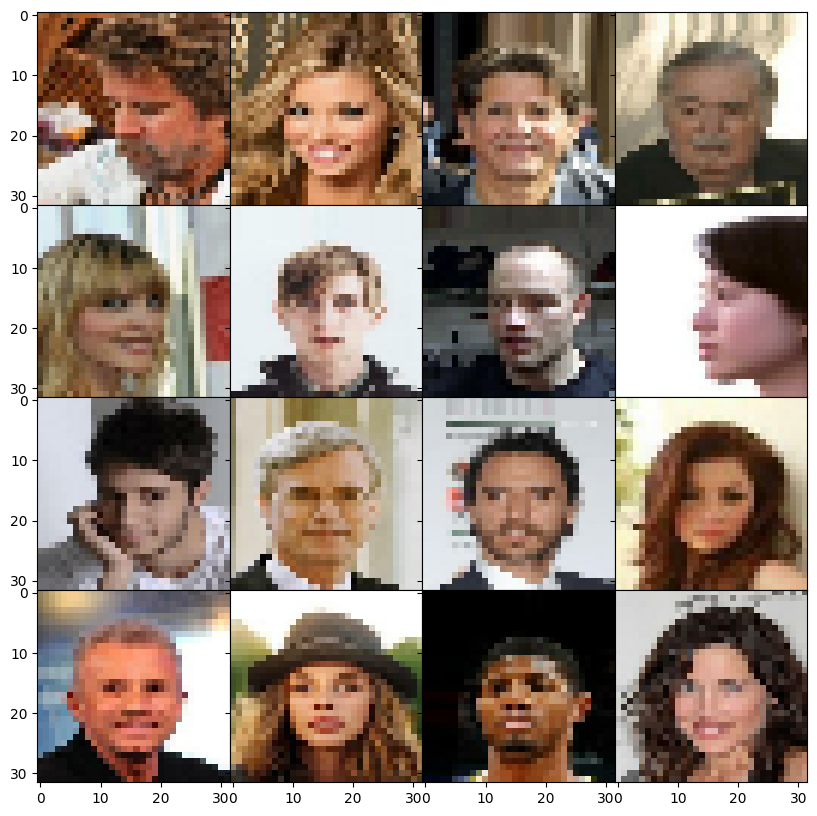

In [7]:
# Get a sample batch
it = iter(dataset)
one_batch = next(it).numpy()
images = one_batch[:16, :, :, :]

# Show some images with ImageGrid
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0,
                 )

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

In [8]:
def generator_model(z_dim=100):

  gen_inputs = Input(shape=(z_dim,), name='generator_input')

  x = layers.Dense(8 * 8 * 3)(gen_inputs)
  x = layers.Reshape(target_shape=(8, 8, 3))(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=512, kernel_size=3, strides=(1, 1), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=256, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=(1, 1), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(1, 1), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=3, kernel_size=3, strides=(1, 1), padding='same')(x)
  images = layers.LeakyReLU()(x)

  model = Model(inputs=gen_inputs, outputs=images)
  return model

In [9]:
def discriminator_model():
  disc_inputs = Input(shape=(32, 32, 3), name='discriminator_input')
  x = layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding='same')(disc_inputs)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(1)(x)
  output = layers.Activation('sigmoid')(x)

  disc = Model(inputs=disc_inputs, outputs=output)
  return disc

In [10]:
gen_model = generator_model()
disc_model = discriminator_model()

# Compile the model that trains discriminator
disc_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Compile the model that trains generator
z_dim = 100

disc_model.trainable = False
model_input = Input(shape=(z_dim,), name='model_input')
model_output = disc_model(gen_model(model_input))

model = Model(model_input, model_output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

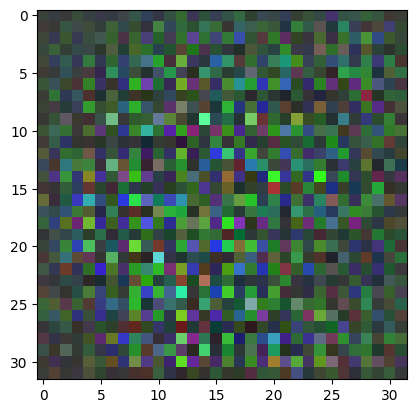

In [11]:
import os

# Generate noise and create the image using your model
noise1 = np.random.normal(0, 1, (1, 100))
image = gen_model(noise1)

# Convert the image to a format suitable for saving
image = tf.keras.preprocessing.image.array_to_img(image[0].numpy())

# Define the path
path = '/content/generated_images'

# Create the directory if it doesn't exist
os.makedirs(path, exist_ok=True)

# Save the image
tf.keras.preprocessing.image.save_img(f'{path}/deneme.jpg', image)

# Display the image
plt.imshow(image)
plt.show()

In [28]:
def train_discriminator(batch, batch_size):
  valid = np.ones((batch_size, 1))
  fake = np.zeros((batch_size ,1))

  # Train on real images
  disc_model.train_on_batch(batch, valid)

  # Train on generated images
  noise = np.random.normal(0, 1, (batch_size, z_dim))
  gen_imgs = gen_model.predict(noise)
  disc_model.train_on_batch(gen_imgs, fake)

def train_generator(batch_size):
  valid = np.ones((batch_size, 1))
  noise = np.random.normal(0, 1, (batch_size, z_dim))
  model.train_on_batch(noise, valid)

epoch no. 0
4/4 [==============================] - 0s 9ms/step
batch no. 0
1/1 [==============================] - 0s 21ms/step


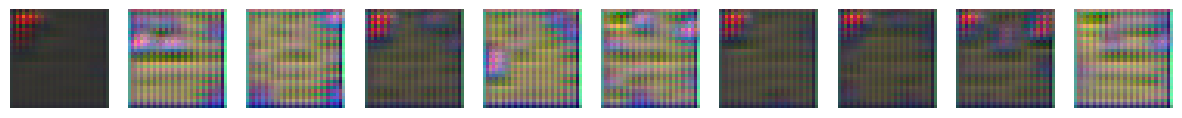

4/4 [==============================] - 0s 6ms/step
batch no. 2
1/1 [==============================] - 0s 21ms/step


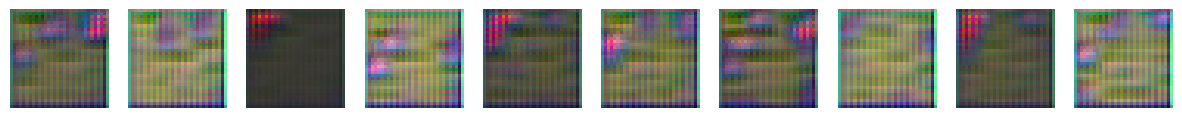

4/4 [==============================] - 0s 6ms/step
batch no. 4
1/1 [==============================] - 0s 20ms/step


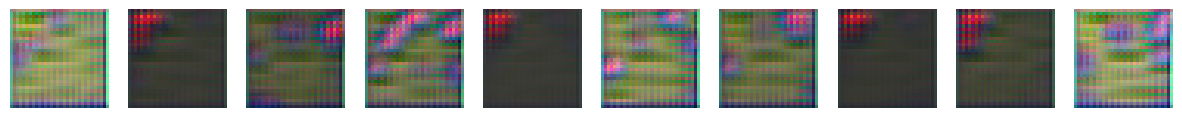

4/4 [==============================] - 0s 5ms/step
batch no. 6
1/1 [==============================] - 0s 32ms/step


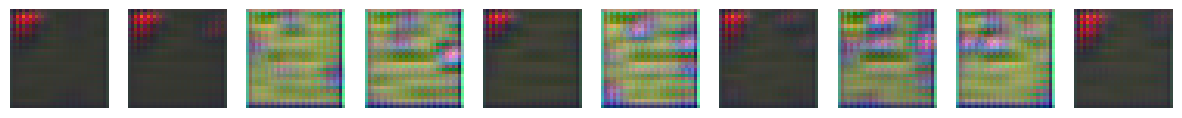

4/4 [==============================] - 0s 5ms/step
batch no. 8
1/1 [==============================] - 0s 28ms/step


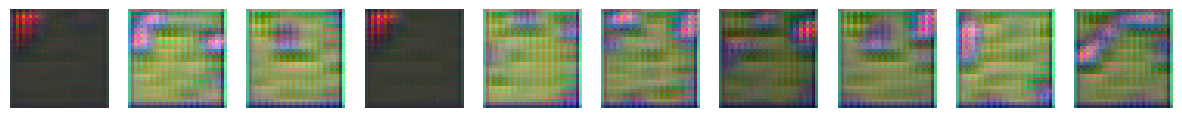

4/4 [==============================] - 0s 6ms/step
epoch no. 1
4/4 [==============================] - 0s 10ms/step
batch no. 0
1/1 [==============================] - 0s 20ms/step


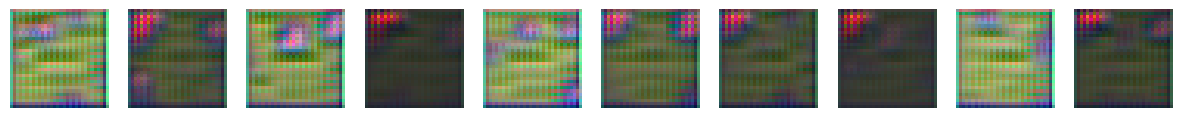

4/4 [==============================] - 0s 5ms/step
batch no. 2
1/1 [==============================] - 0s 22ms/step


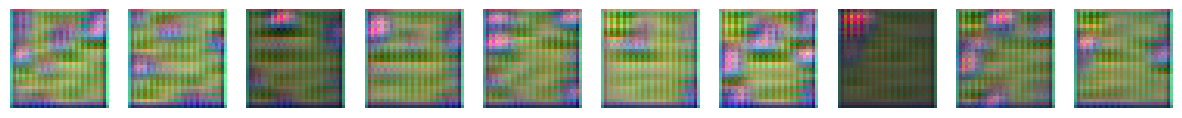

4/4 [==============================] - 0s 5ms/step
batch no. 4
1/1 [==============================] - 0s 20ms/step


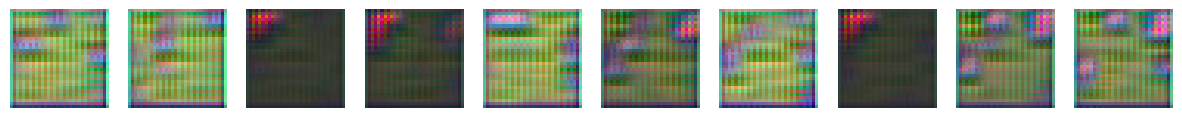

4/4 [==============================] - 0s 5ms/step
batch no. 6
1/1 [==============================] - 0s 24ms/step


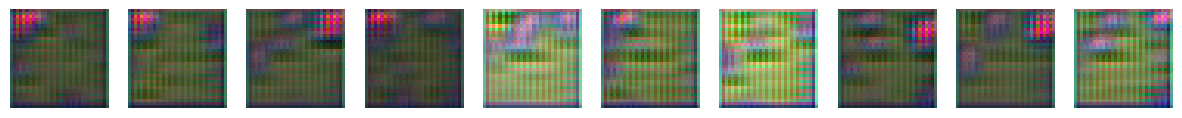

4/4 [==============================] - 0s 5ms/step
batch no. 8
1/1 [==============================] - 0s 23ms/step


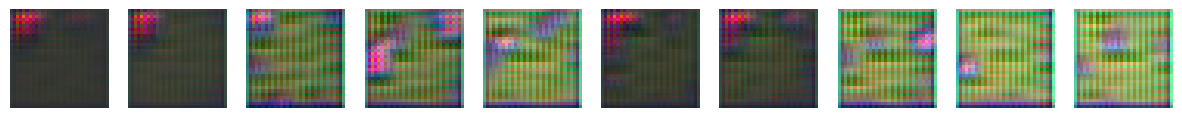

4/4 [==============================] - 0s 5ms/step
epoch no. 2
4/4 [==============================] - 0s 8ms/step
batch no. 0
1/1 [==============================] - 0s 21ms/step


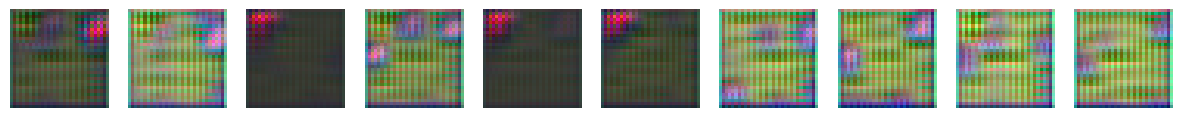

4/4 [==============================] - 0s 6ms/step
batch no. 2
1/1 [==============================] - 0s 33ms/step


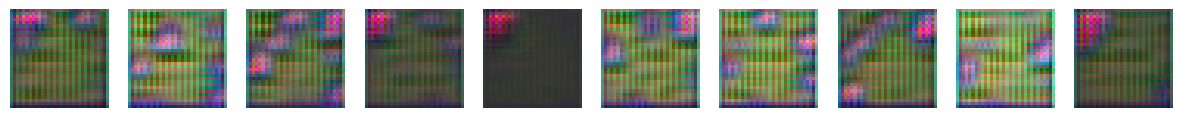

4/4 [==============================] - 0s 7ms/step
batch no. 4
1/1 [==============================] - 0s 32ms/step


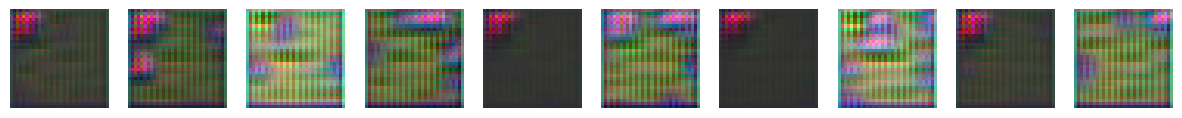

4/4 [==============================] - 0s 5ms/step
batch no. 6
1/1 [==============================] - 0s 20ms/step


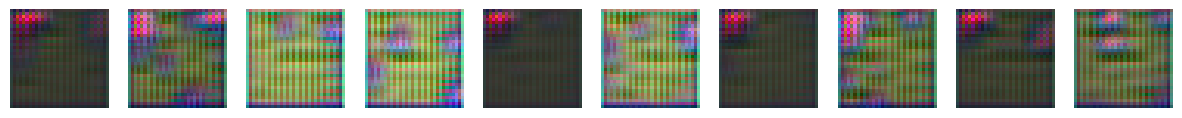

4/4 [==============================] - 0s 5ms/step
batch no. 8
1/1 [==============================] - 0s 23ms/step


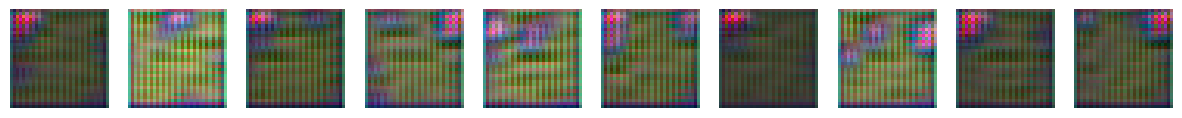

4/4 [==============================] - 0s 5ms/step
epoch no. 3
4/4 [==============================] - 0s 8ms/step
batch no. 0
1/1 [==============================] - 0s 21ms/step


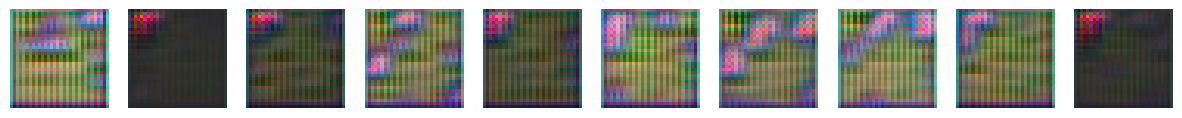

4/4 [==============================] - 0s 5ms/step
batch no. 2
1/1 [==============================] - 0s 22ms/step


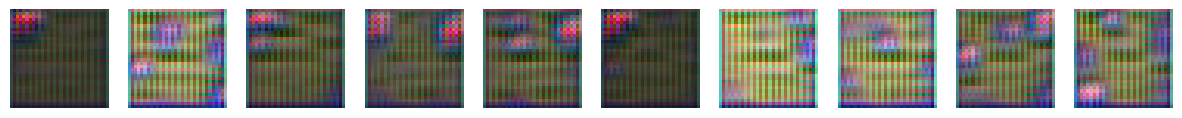

4/4 [==============================] - 0s 6ms/step
batch no. 4
1/1 [==============================] - 0s 23ms/step


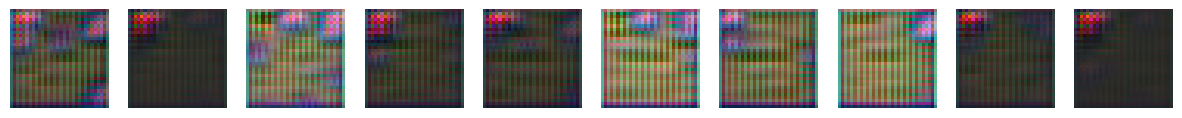

4/4 [==============================] - 0s 5ms/step
batch no. 6
1/1 [==============================] - 0s 22ms/step


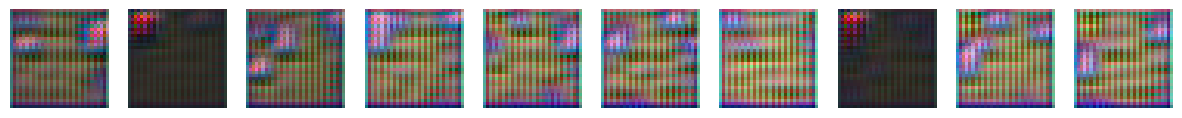

4/4 [==============================] - 0s 5ms/step
batch no. 8
1/1 [==============================] - 0s 28ms/step


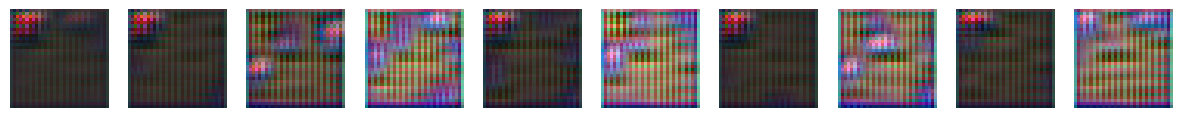

4/4 [==============================] - 0s 5ms/step
epoch no. 4
4/4 [==============================] - 0s 7ms/step
batch no. 0
1/1 [==============================] - 0s 22ms/step


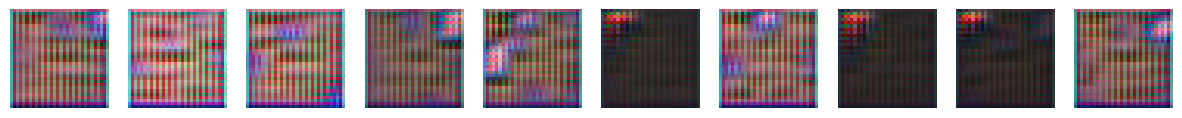

4/4 [==============================] - 0s 6ms/step
batch no. 2
1/1 [==============================] - 0s 24ms/step


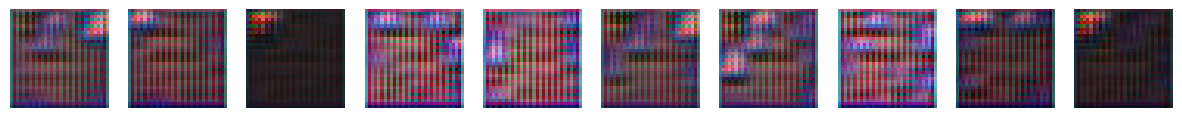

4/4 [==============================] - 0s 6ms/step
batch no. 4
1/1 [==============================] - 0s 21ms/step


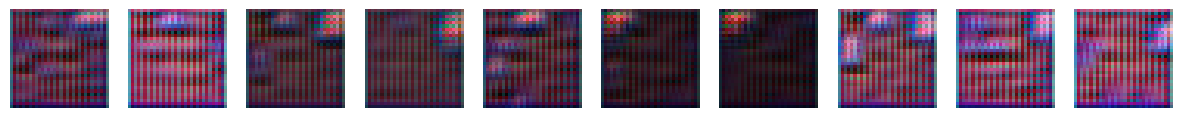

4/4 [==============================] - 0s 5ms/step
batch no. 6
1/1 [==============================] - 0s 28ms/step


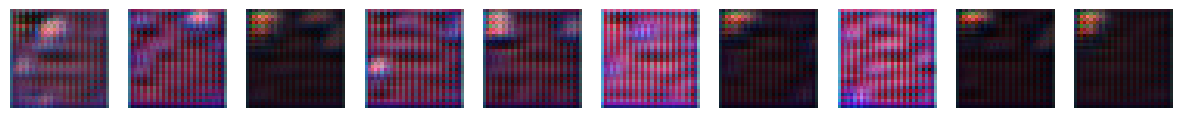

4/4 [==============================] - 0s 7ms/step
batch no. 8
1/1 [==============================] - 0s 28ms/step


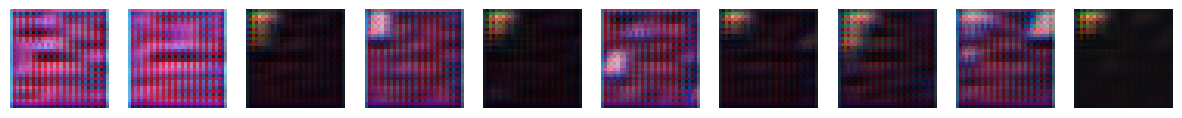

4/4 [==============================] - 0s 5ms/step
epoch no. 5
4/4 [==============================] - 0s 12ms/step
batch no. 0
1/1 [==============================] - 0s 19ms/step


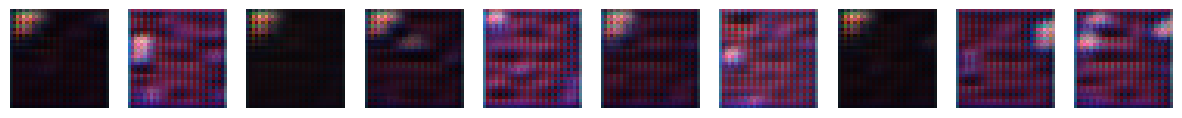

4/4 [==============================] - 0s 7ms/step
batch no. 2
1/1 [==============================] - 0s 28ms/step


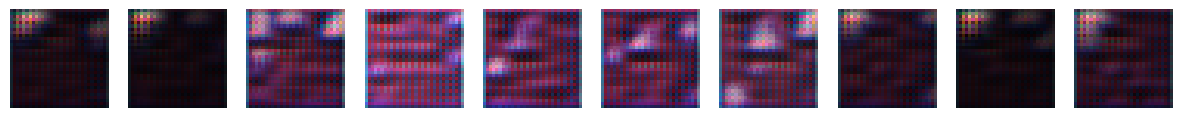

4/4 [==============================] - 0s 6ms/step
batch no. 4
1/1 [==============================] - 0s 27ms/step


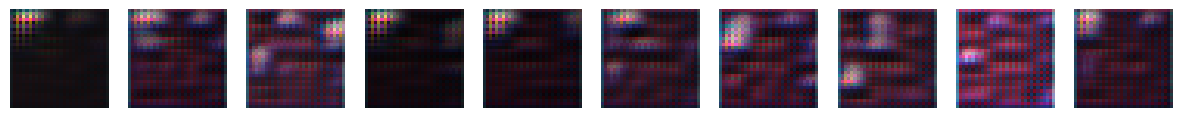

4/4 [==============================] - 0s 5ms/step
batch no. 6
1/1 [==============================] - 0s 23ms/step


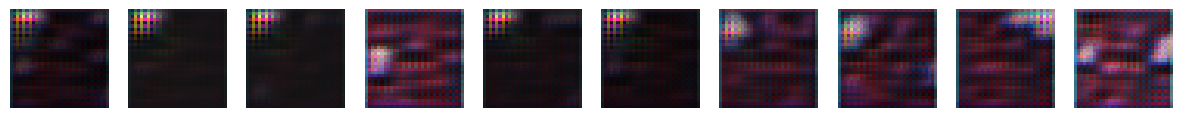

4/4 [==============================] - 0s 5ms/step
batch no. 8
1/1 [==============================] - 0s 26ms/step


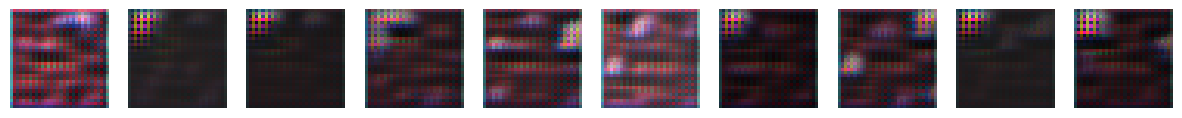

4/4 [==============================] - 0s 5ms/step
epoch no. 6
4/4 [==============================] - 0s 8ms/step
batch no. 0
1/1 [==============================] - 0s 29ms/step


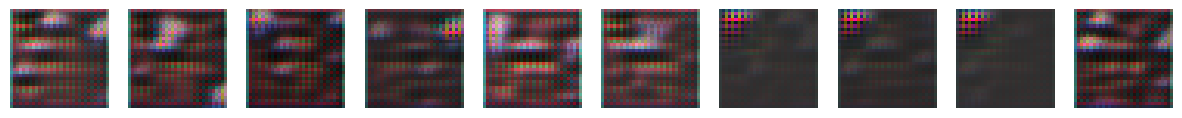

4/4 [==============================] - 0s 8ms/step
batch no. 2
1/1 [==============================] - 0s 33ms/step


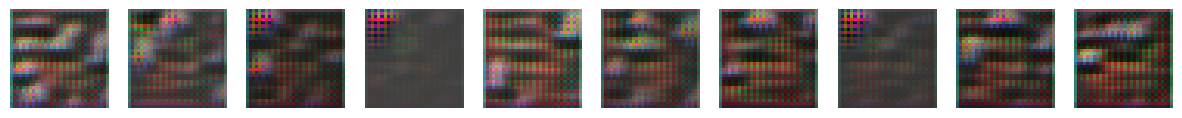

4/4 [==============================] - 0s 9ms/step
batch no. 4
1/1 [==============================] - 0s 39ms/step


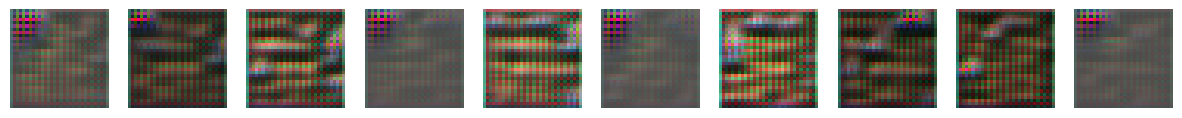

4/4 [==============================] - 0s 8ms/step
batch no. 6
1/1 [==============================] - 0s 27ms/step


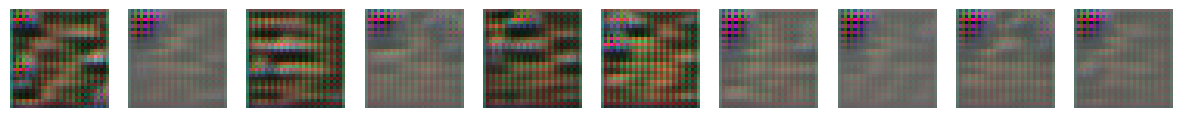

4/4 [==============================] - 0s 6ms/step
batch no. 8
1/1 [==============================] - 0s 25ms/step


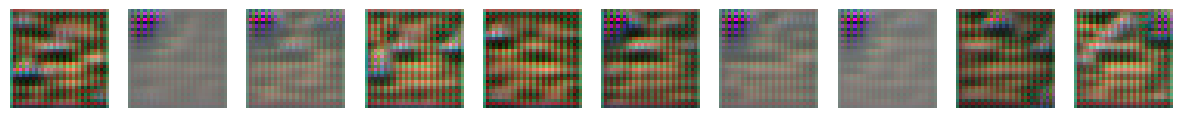

4/4 [==============================] - 0s 5ms/step
epoch no. 7
4/4 [==============================] - 0s 6ms/step
batch no. 0
1/1 [==============================] - 0s 19ms/step


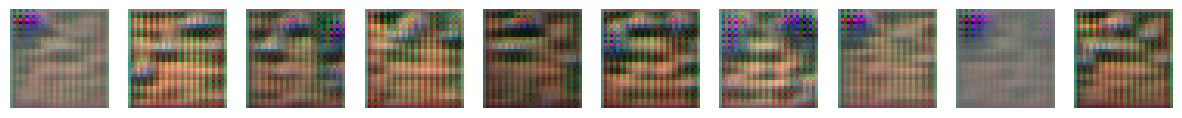

4/4 [==============================] - 0s 5ms/step
batch no. 2
1/1 [==============================] - 0s 21ms/step


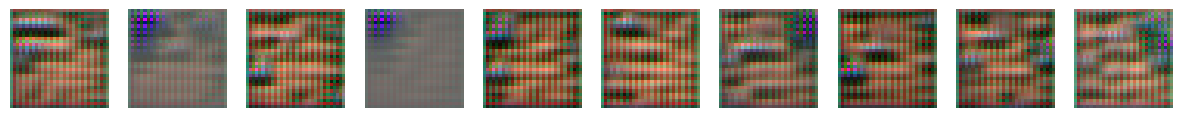

4/4 [==============================] - 0s 5ms/step
batch no. 4
1/1 [==============================] - 0s 27ms/step


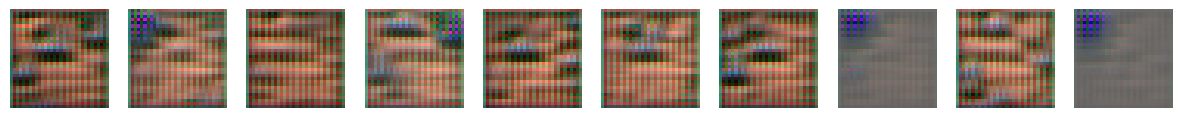

4/4 [==============================] - 0s 5ms/step
batch no. 6
1/1 [==============================] - 0s 29ms/step


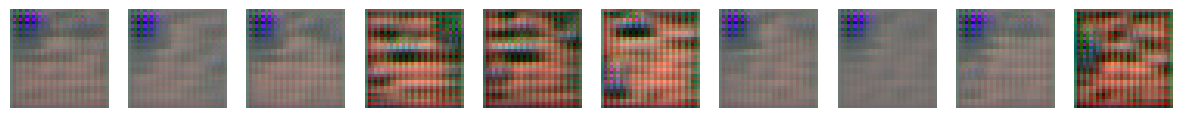

4/4 [==============================] - 0s 5ms/step
batch no. 8
1/1 [==============================] - 0s 27ms/step


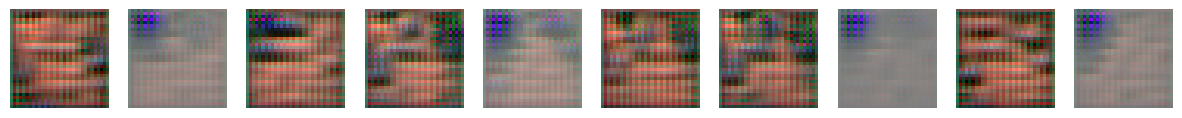

4/4 [==============================] - 0s 6ms/step
epoch no. 8
4/4 [==============================] - 0s 13ms/step
batch no. 0
1/1 [==============================] - 0s 23ms/step


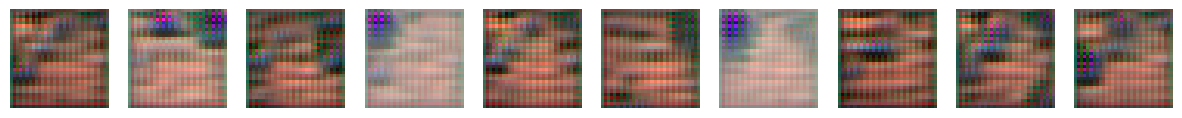

4/4 [==============================] - 0s 5ms/step
batch no. 2
1/1 [==============================] - 0s 27ms/step


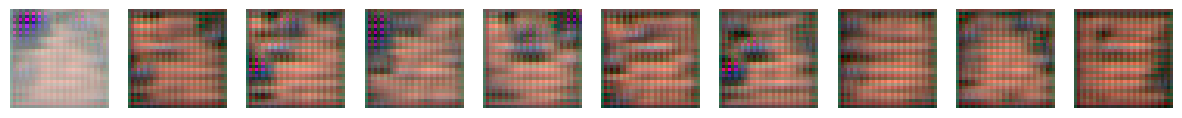

4/4 [==============================] - 0s 6ms/step
batch no. 4
1/1 [==============================] - 0s 19ms/step


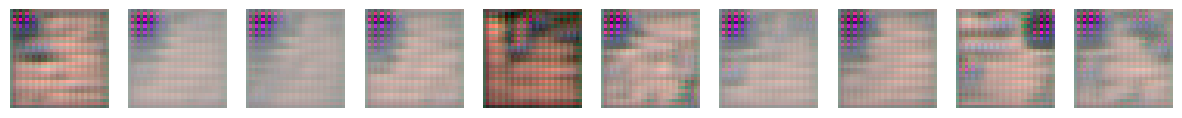

4/4 [==============================] - 0s 7ms/step
batch no. 6
1/1 [==============================] - 0s 29ms/step


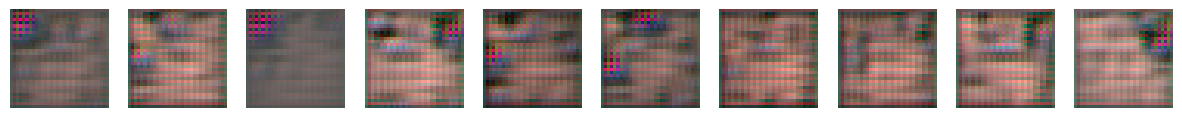

4/4 [==============================] - 0s 10ms/step
batch no. 8
1/1 [==============================] - 0s 30ms/step


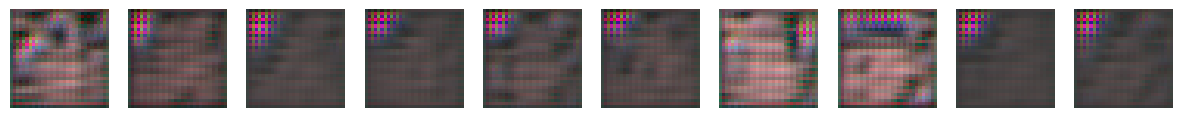

4/4 [==============================] - 0s 9ms/step
epoch no. 9
4/4 [==============================] - 0s 11ms/step
batch no. 0
1/1 [==============================] - 0s 23ms/step


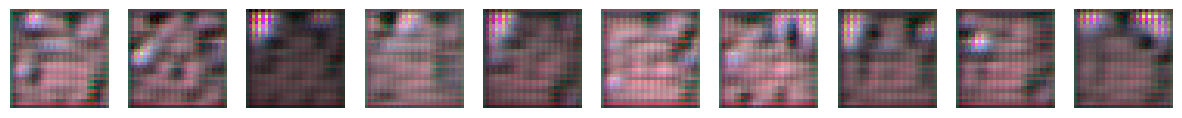

4/4 [==============================] - 0s 6ms/step
batch no. 2
1/1 [==============================] - 0s 26ms/step


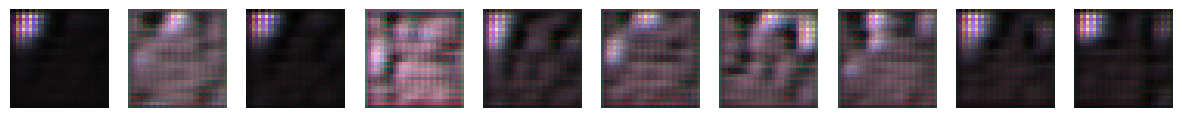

4/4 [==============================] - 0s 6ms/step
batch no. 4
1/1 [==============================] - 0s 22ms/step


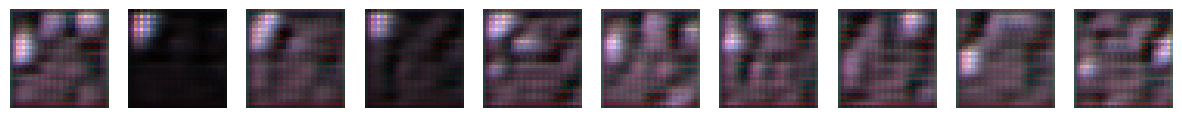

4/4 [==============================] - 0s 6ms/step
batch no. 6
1/1 [==============================] - 0s 29ms/step


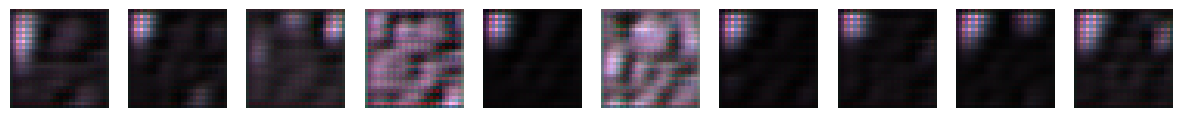

4/4 [==============================] - 0s 5ms/step
batch no. 8
1/1 [==============================] - 0s 23ms/step


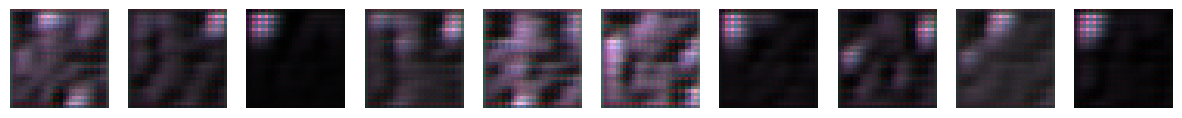

4/4 [==============================] - 0s 5ms/step
epoch no. 10
4/4 [==============================] - 0s 6ms/step
batch no. 0
1/1 [==============================] - 0s 30ms/step


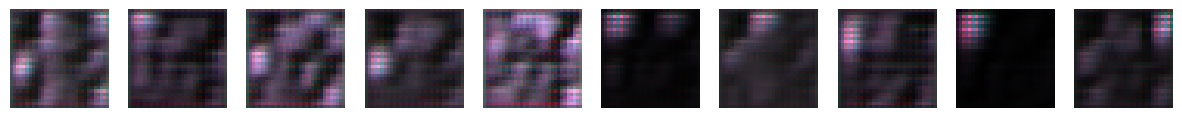

4/4 [==============================] - 0s 9ms/step
batch no. 2
1/1 [==============================] - 0s 56ms/step


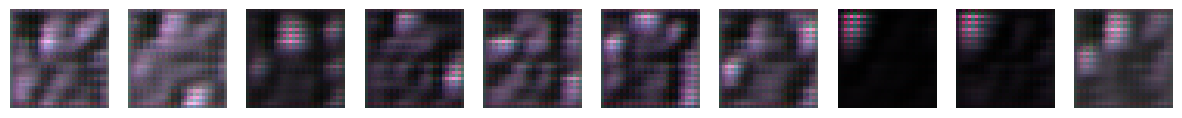

4/4 [==============================] - 0s 7ms/step
batch no. 4
1/1 [==============================] - 0s 33ms/step


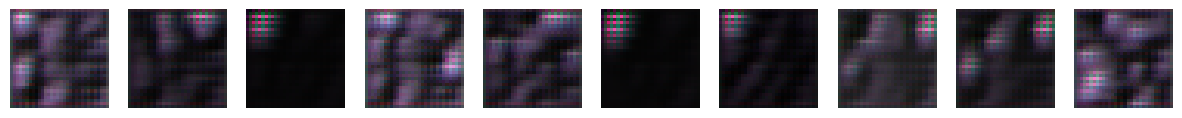

4/4 [==============================] - 0s 7ms/step
batch no. 6
1/1 [==============================] - 0s 26ms/step


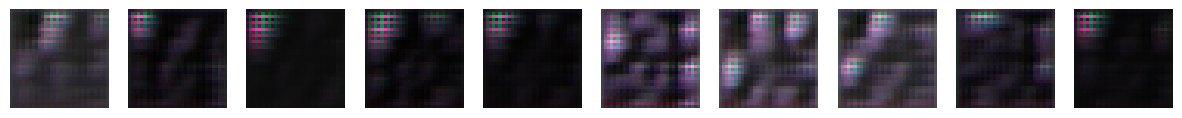

4/4 [==============================] - 0s 6ms/step
batch no. 8
1/1 [==============================] - 0s 24ms/step


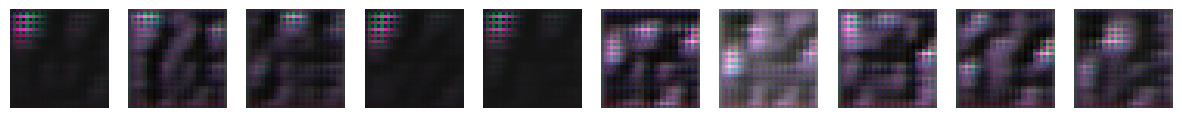

4/4 [==============================] - 0s 5ms/step
epoch no. 11
4/4 [==============================] - 0s 16ms/step
batch no. 0
1/1 [==============================] - 0s 19ms/step


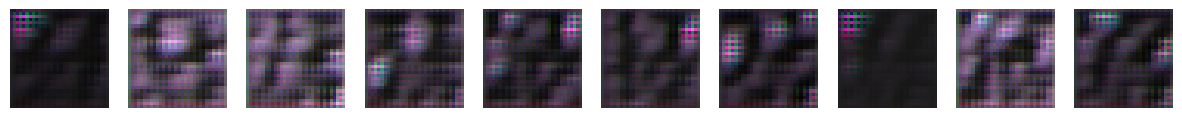

4/4 [==============================] - 0s 5ms/step
batch no. 2
1/1 [==============================] - 0s 21ms/step


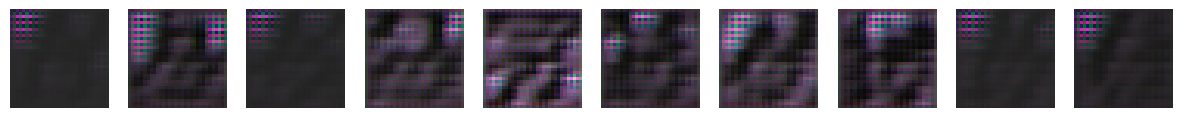

4/4 [==============================] - 0s 5ms/step
batch no. 4
1/1 [==============================] - 0s 19ms/step


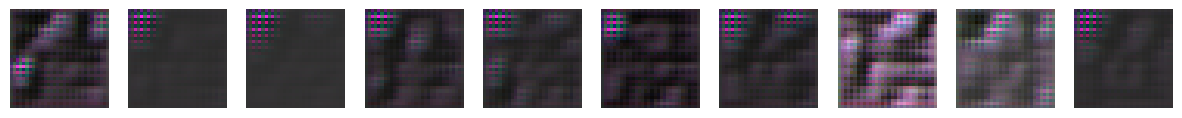

4/4 [==============================] - 0s 6ms/step
batch no. 6
1/1 [==============================] - 0s 30ms/step


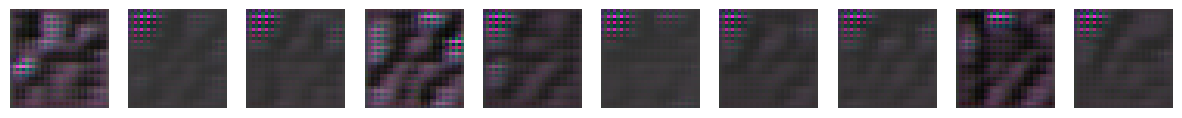

4/4 [==============================] - 0s 5ms/step
batch no. 8
1/1 [==============================] - 0s 31ms/step


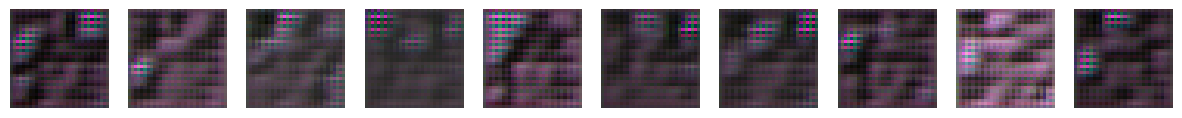

4/4 [==============================] - 0s 6ms/step
epoch no. 12
4/4 [==============================] - 0s 8ms/step
batch no. 0
1/1 [==============================] - 0s 22ms/step


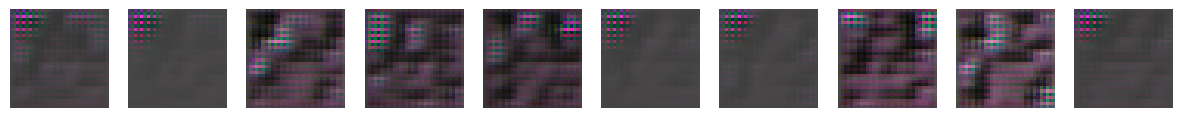

4/4 [==============================] - 0s 5ms/step
batch no. 2
1/1 [==============================] - 0s 27ms/step


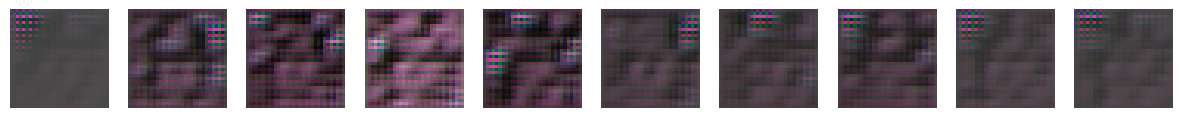

4/4 [==============================] - 0s 6ms/step
batch no. 4
1/1 [==============================] - 0s 33ms/step


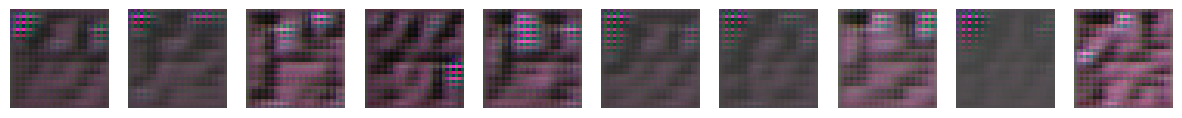

4/4 [==============================] - 0s 9ms/step
batch no. 6
1/1 [==============================] - 0s 29ms/step


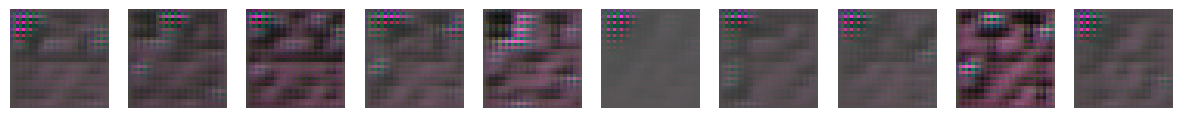

4/4 [==============================] - 0s 8ms/step
batch no. 8
1/1 [==============================] - 0s 33ms/step


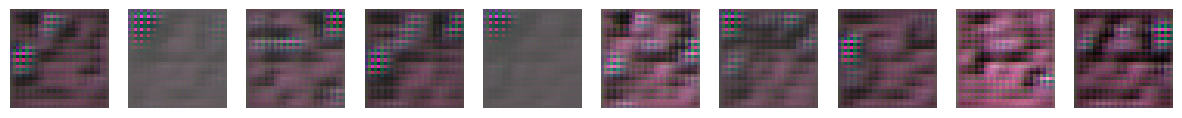

4/4 [==============================] - 0s 5ms/step
epoch no. 13
4/4 [==============================] - 0s 9ms/step
batch no. 0
1/1 [==============================] - 0s 20ms/step


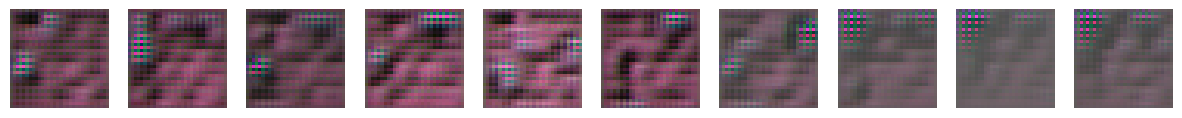

4/4 [==============================] - 0s 6ms/step
batch no. 2
1/1 [==============================] - 0s 28ms/step


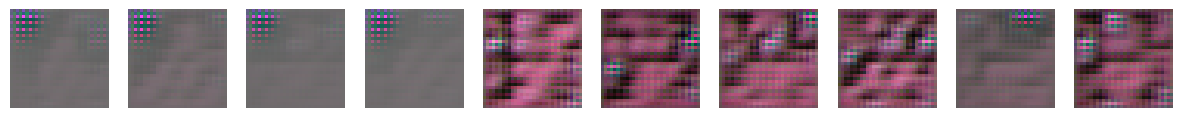

4/4 [==============================] - 0s 6ms/step
batch no. 4
1/1 [==============================] - 0s 32ms/step


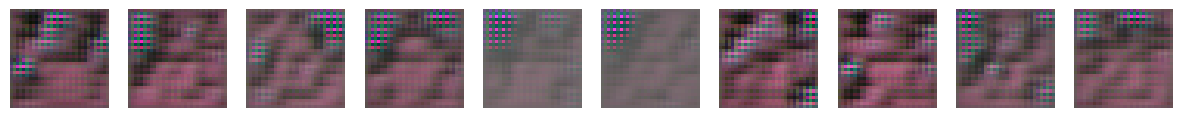

4/4 [==============================] - 0s 5ms/step
batch no. 6
1/1 [==============================] - 0s 26ms/step


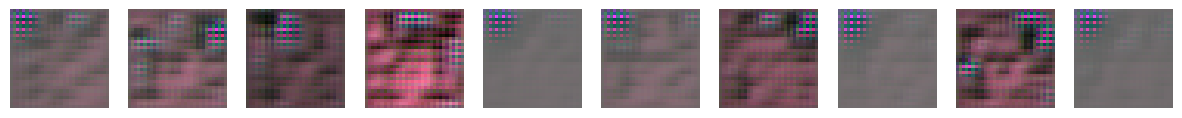

4/4 [==============================] - 0s 5ms/step
batch no. 8
1/1 [==============================] - 0s 29ms/step


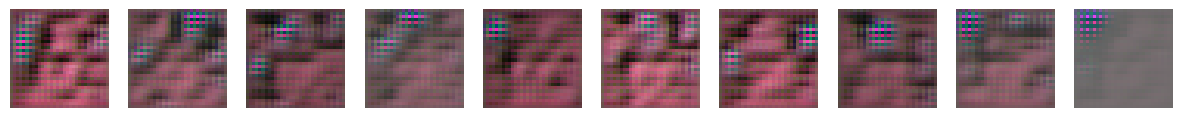

4/4 [==============================] - 0s 6ms/step
epoch no. 14
4/4 [==============================] - 0s 12ms/step
batch no. 0
1/1 [==============================] - 0s 44ms/step


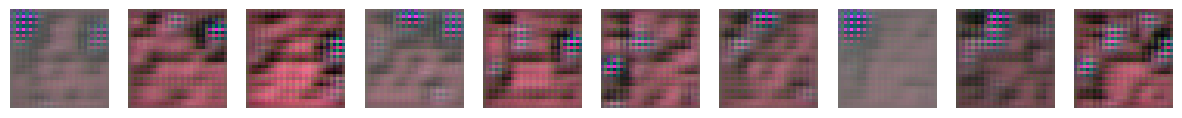

4/4 [==============================] - 0s 10ms/step
batch no. 2
1/1 [==============================] - 0s 31ms/step


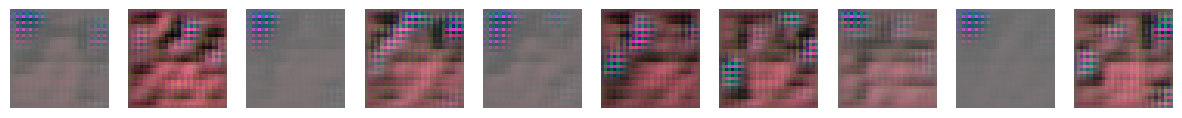

4/4 [==============================] - 0s 8ms/step
batch no. 4
1/1 [==============================] - 0s 29ms/step


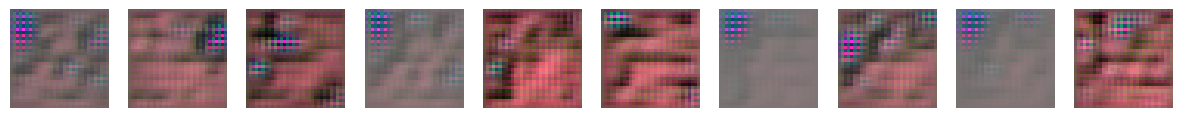

4/4 [==============================] - 0s 5ms/step
batch no. 6
1/1 [==============================] - 0s 19ms/step


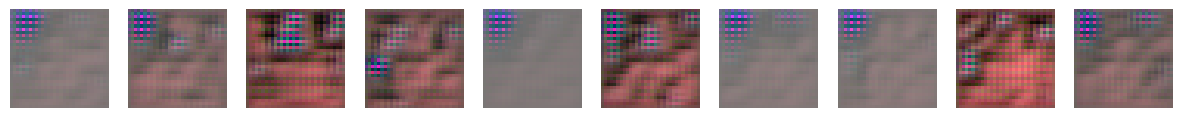

4/4 [==============================] - 0s 6ms/step
batch no. 8
1/1 [==============================] - 0s 19ms/step


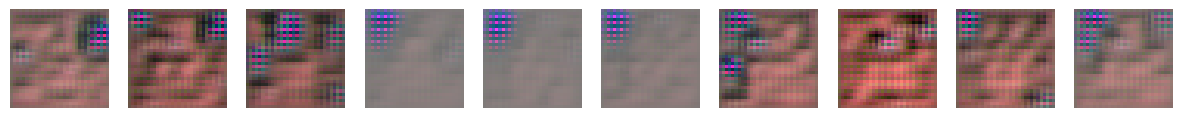

4/4 [==============================] - 0s 5ms/step
epoch no. 15
4/4 [==============================] - 0s 12ms/step
batch no. 0
1/1 [==============================] - 0s 22ms/step


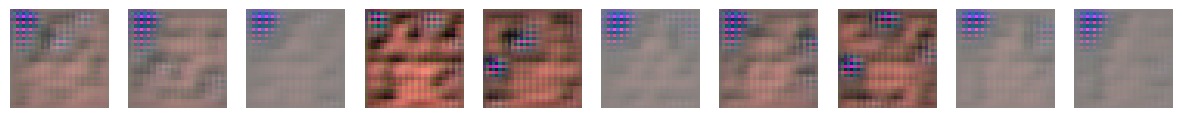

4/4 [==============================] - 0s 5ms/step
batch no. 2
1/1 [==============================] - 0s 19ms/step


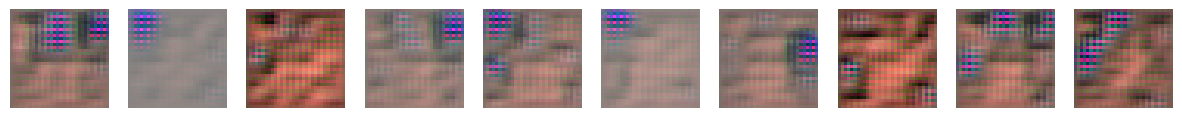

4/4 [==============================] - 0s 5ms/step
batch no. 4
1/1 [==============================] - 0s 28ms/step


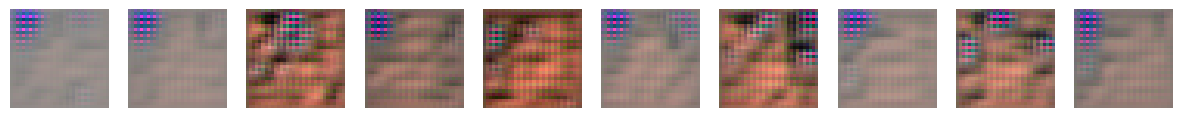

4/4 [==============================] - 0s 5ms/step
batch no. 6
1/1 [==============================] - 0s 20ms/step


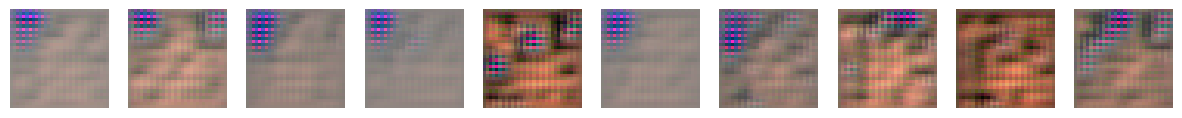

4/4 [==============================] - 0s 5ms/step
batch no. 8
1/1 [==============================] - 0s 39ms/step


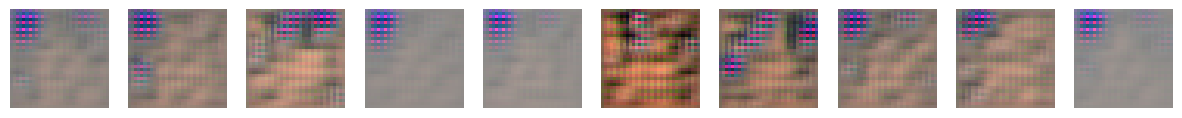

4/4 [==============================] - 0s 5ms/step
epoch no. 16
4/4 [==============================] - 0s 11ms/step
batch no. 0
1/1 [==============================] - 0s 22ms/step


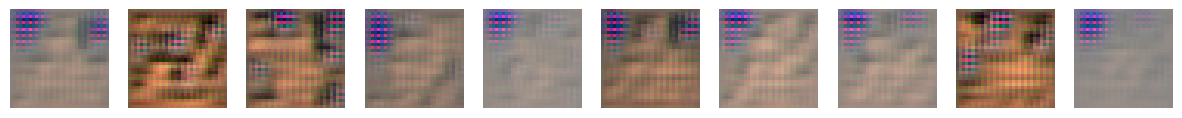

4/4 [==============================] - 0s 6ms/step
batch no. 2
1/1 [==============================] - 0s 31ms/step


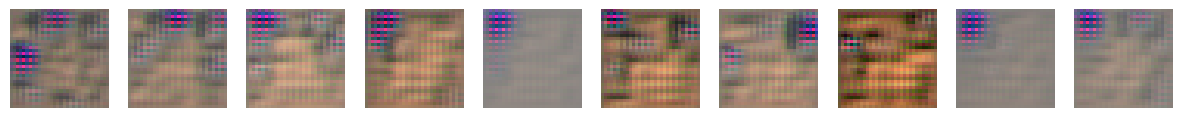

4/4 [==============================] - 0s 6ms/step
batch no. 4
1/1 [==============================] - 0s 21ms/step


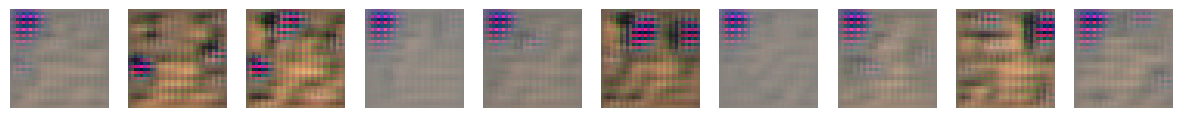

4/4 [==============================] - 0s 9ms/step
batch no. 6
1/1 [==============================] - 0s 30ms/step


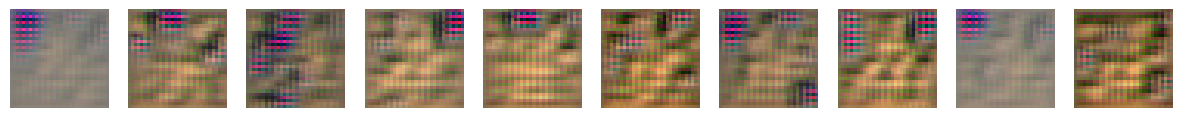

4/4 [==============================] - 0s 5ms/step
batch no. 8
1/1 [==============================] - 0s 33ms/step


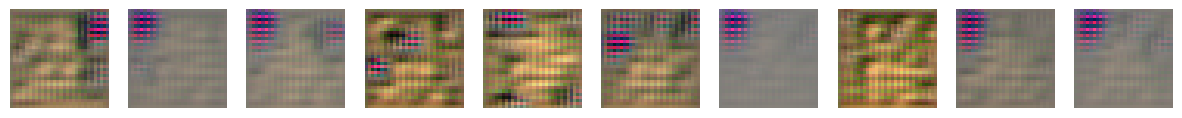

4/4 [==============================] - 0s 7ms/step
epoch no. 17
4/4 [==============================] - 0s 9ms/step
batch no. 0
1/1 [==============================] - 0s 19ms/step


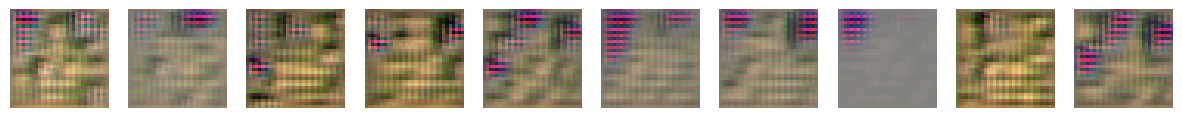

4/4 [==============================] - 0s 6ms/step
batch no. 2
1/1 [==============================] - 0s 34ms/step


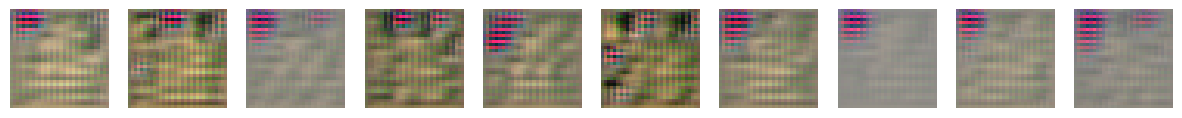

4/4 [==============================] - 0s 5ms/step
batch no. 4
1/1 [==============================] - 0s 20ms/step


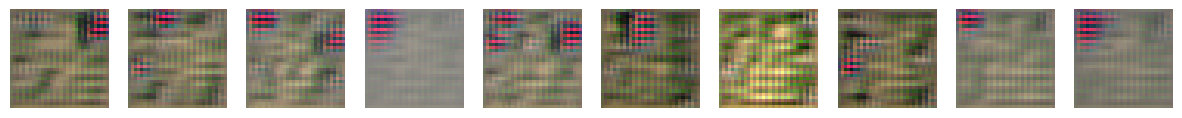

4/4 [==============================] - 0s 5ms/step
batch no. 6
1/1 [==============================] - 0s 27ms/step


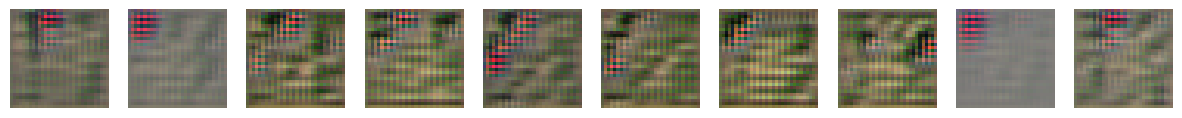

4/4 [==============================] - 0s 5ms/step
batch no. 8
1/1 [==============================] - 0s 47ms/step


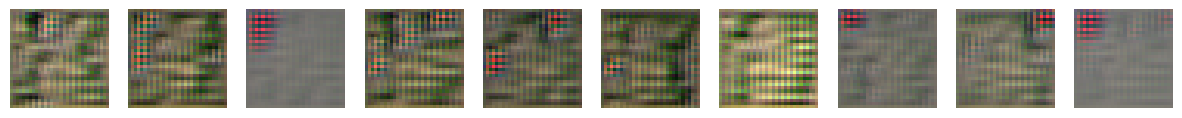

4/4 [==============================] - 0s 5ms/step
epoch no. 18
4/4 [==============================] - 0s 5ms/step
batch no. 0
1/1 [==============================] - 0s 21ms/step


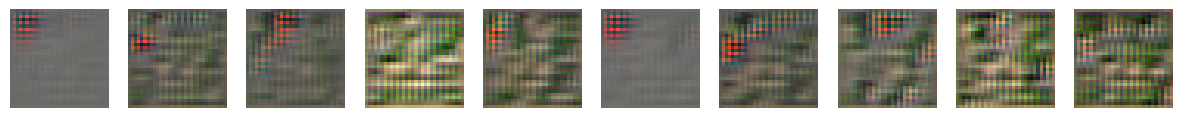

4/4 [==============================] - 0s 5ms/step
batch no. 2
1/1 [==============================] - 0s 29ms/step


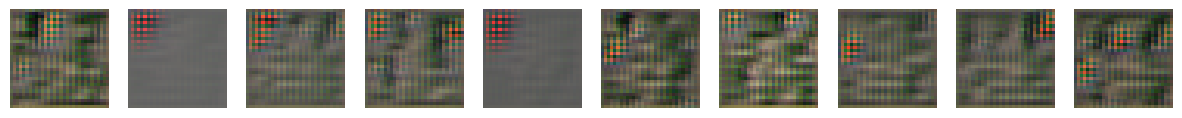

4/4 [==============================] - 0s 6ms/step
batch no. 4
1/1 [==============================] - 0s 45ms/step


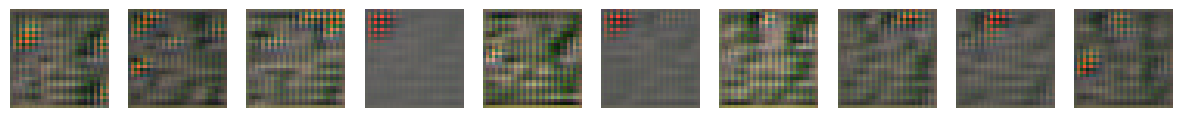

4/4 [==============================] - 0s 6ms/step
batch no. 6
1/1 [==============================] - 0s 50ms/step


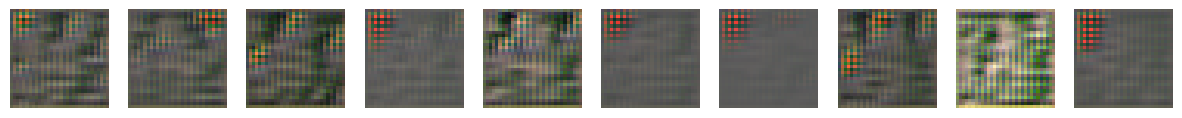

4/4 [==============================] - 0s 6ms/step
batch no. 8
1/1 [==============================] - 0s 43ms/step


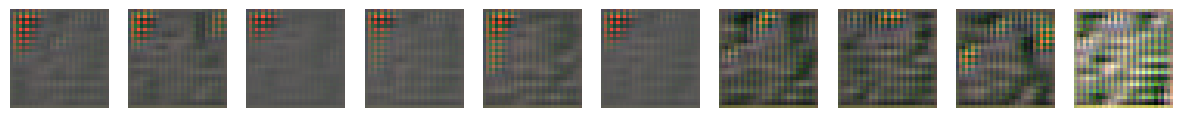

4/4 [==============================] - 0s 6ms/step
epoch no. 19
4/4 [==============================] - 0s 10ms/step
batch no. 0
1/1 [==============================] - 0s 20ms/step


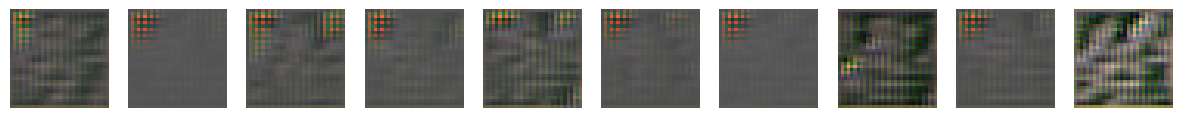

4/4 [==============================] - 0s 7ms/step
batch no. 2
1/1 [==============================] - 0s 33ms/step


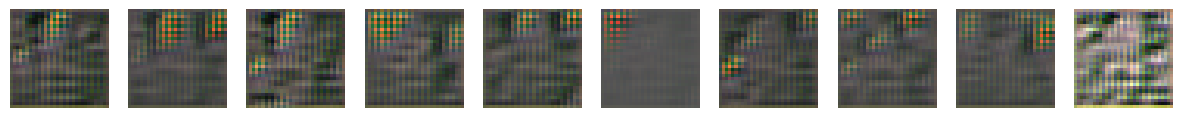

4/4 [==============================] - 0s 5ms/step
batch no. 4
1/1 [==============================] - 0s 28ms/step


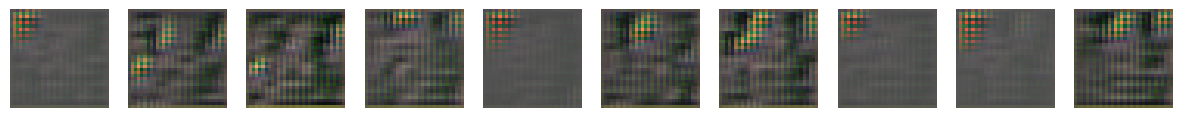

4/4 [==============================] - 0s 5ms/step
batch no. 6
1/1 [==============================] - 0s 28ms/step


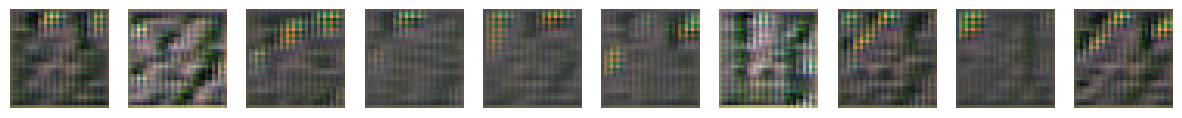

4/4 [==============================] - 0s 5ms/step
batch no. 8
1/1 [==============================] - 0s 33ms/step


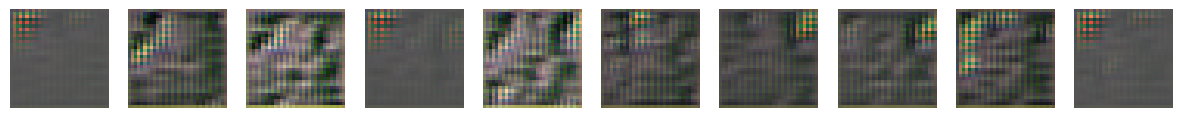

4/4 [==============================] - 0s 5ms/step


In [36]:
def generate_and_save_images(path, num_images=10):
    noise = np.random.normal(0, 1, (num_images, z_dim))
    generated_images = gen_model.predict(noise)

    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        image = tf.keras.preprocessing.image.array_to_img(generated_images[i])
        save_path = os.path.join(path, f'img_{i}.jpg')
        tf.keras.preprocessing.image.save_img(save_path, image)

        # Display the images
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()

epochs = 20
batches_per_epoch = 10  # Limit the number of batches processed per epoch
images_to_generate = 10  # Number of images to generate

path = '/content/generated_images'
os.makedirs(path, exist_ok=True)

for epoch in range(epochs):
    print(f'epoch no. {epoch}')
    for i, batch in enumerate(dataset.take(batches_per_epoch)):
        train_discriminator(batch, batch.shape[0])
        train_generator(batch.shape[0])
        if i % 2 == 0:  # Adjusted to generate images more frequently for demonstration
            print(f'batch no. {i}')
            generate_and_save_images(path=path, num_images=images_to_generate)

1/1 [==============================] - 0s 25ms/step


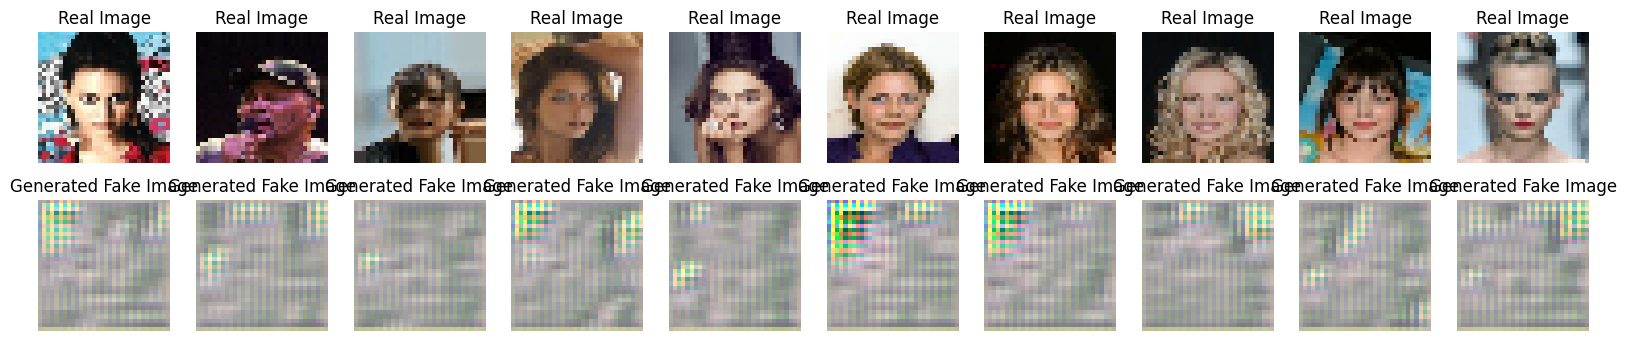

In [41]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to generate real images from the dataset using the generator model
def generate_real_images(gen_model, dataset, num_images=10):
    # Get 10 random real images from the dataset
    real_images = next(iter(dataset.unbatch().shuffle(buffer_size=10000).batch(num_images)))

    # Generate fake images from noise
    noise = np.random.normal(0, 1, (num_images, z_dim))
    generated_images = gen_model.predict(noise)

    # Normalize the generated images to range [0, 1]
    generated_images = (generated_images + 1) / 2.0

    # Display the generated images
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Display real image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(real_images[i])
        plt.title("Real Image")
        plt.axis('off')

        # Display fake image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(generated_images[i])
        plt.title("Generated Fake Image")
        plt.axis('off')

    plt.show()

# Assuming gen_model and dataset are already defined
generate_real_images(gen_model, dataset)
